In [12]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# Load protein data
from fff.data import load_dataset
from fff.evaluate.tori import convert_to_angles
protein_dataset = load_dataset("torus_protein", root="/home/armand/PhD/M-FFF2/fff/data")
trainset, valset, testset = [convert_to_angles(ds[:][0].to(device)) for ds in protein_dataset]

In [14]:
import zuko

In [31]:
config = {
    "lr": 2.e-4,
    "epochs": 20,
    "network": {
        "hidden_features": [128] * 3,
        "transforms": 8,
    },
    "batch_size": 512,
    
}

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config["batch_size"], shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=config["batch_size"], shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=config["batch_size"], shuffle=True)

In [33]:
flow = zuko.flows.NCSF(2, 1, **config["network"]).to(device)
print(f"Thy flow hath {sum([p.numel() for p in flow.parameters()])} parameters, sire.")
optimizer = torch.optim.Adam(flow.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config["lr"], epochs=config["epochs"], steps_per_epoch=len(trainloader))

Thy flow hath 315760 parameters, sire.


In [34]:
from tqdm.auto import trange

pbar = trange(config["epochs"])

for epoch in pbar:
    for x in trainloader:
        c = torch.zeros_like(x[:,:1])
        loss = -flow(c).log_prob(x)  # -log p(x | c)
        loss = loss.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        val_loss = 0.0
        for x in valloader:
            c = torch.zeros_like(x[:,:1])
            loss = -flow(c).log_prob(x)  # -log p(x | c)
            val_loss += loss.mean()/len(valloader)
    pbar.set_description(f"Validation Loss: {val_loss.item():.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
from typing import Optional
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_model_log_densities(
    model,
    reference_data = None,
    num_grid_points: int = 200,
    levels: int = 10,
    ax: Optional[plt.Axes] = None,
    fontsizes: dict = dict(TITLESIZE=24, LABELSIZE=20, TICKSIZE=16),
):
    pass

    if ax is None:
        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111)

    range_angular = torch.linspace(-torch.pi, torch.pi, num_grid_points)
    phi_grid, psi_grid = torch.meshgrid(range_angular, range_angular)
    x = torch.stack((phi_grid, psi_grid), dim=-1).to(device).reshape(-1, 2)
    c = torch.zeros_like(x[:,:1])
    log_prob = flow(c).log_prob(x).cpu()


    phi, psi = x[..., 0].cpu(), x[..., 1].cpu()
    contours = ax.tricontourf(phi, psi, log_prob, levels=levels, cmap="viridis")
    cbar = plt.colorbar(contours)
    cbar.set_label("Log density", fontsize=fontsizes.get("LABELSIZE"))
    cbar.ax.tick_params(labelsize=fontsizes.get("TICKSIZE"))

    ax.set_xlim(-torch.pi, torch.pi)
    ax.set_ylim(-torch.pi, torch.pi)

    ax.set_xticks(
        [-torch.pi, -torch.pi / 2, 0, torch.pi / 2, torch.pi],
        [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"],
    )
    ax.set_yticks(
        [-torch.pi, -torch.pi / 2, 0, torch.pi / 2, torch.pi],
        [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"],
    )
    ax.tick_params(labelsize=fontsizes.get("TICKSIZE"))

    ax.set_xlabel(r"$\Phi$", fontsize=fontsizes.get("LABELSIZE"))
    ax.set_ylabel(r"$\Psi$", fontsize=fontsizes.get("LABELSIZE"))
    
    if reference_data is not None:
        ax.scatter(
            reference_data[..., 0],
            reference_data[..., 1],
            s=1 / len(reference_data) * 2e3,
            c="black",
            alpha=0.1,
            label="validation data",
        )

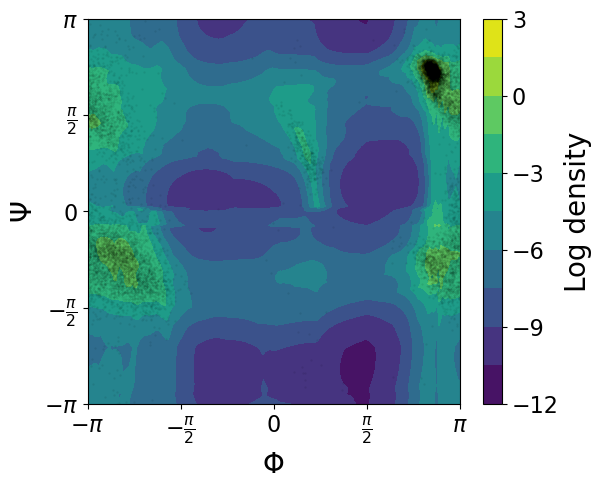

In [47]:
plot_model_log_densities(flow, valset.cpu())